<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils and Imports

In [6]:
def draw_image(image, figsize=(12, 16)):
  plt.figure(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def create_white_image(image):

    # Get the dimensions of the input image
    height, width = image.shape
    channels = 1

    # Create an all-white image with the same dimensions as the input image
    return np.ones((height, width, channels), dtype=np.uint8) * 255

def apply_n_times(func, times, input):
  if times == 1:
    return func(input)
  else:
    return func(apply_n_times(func, times-1, input))


In [ ]:
!apt-get install -y poppler-utils
!pip install PyPDF2 pytesseract pdf2image opencv-python-headless
!pip install pytesseract
!apt install tesseract-ocr
!apt install libtesseract-dev


In [10]:
from PyPDF2 import PdfReader
import cv2
import pytesseract
from pdf2image import convert_from_path
import os
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import math

In [11]:
CIRCUITS_RAW_DIRECTORY = '/content/drive/MyDrive/Photo_Circuit/data/circuits_raw'
CIRCUITS_TEXTBOOK_LOC = '/content/drive/MyDrive/Photo_Circuit/data/Fundamentals_of_Electric_Circuits_6th_Sadiku.pdf'

# Part 1. Extract Closeup of every potential circuit

### Save as Images

In [ ]:
def convert_pdf_to_images(pdf_path, start_page, end_page):
    images = []
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page_num in range(start_page - 1, end_page):
            if reader.is_encrypted:
                reader.decrypt('')
            page = reader.pages[page_num]
            images += convert_from_path(pdf_path, first_page=page_num + 1, last_page=page_num + 1, fmt='jpeg')
    return images

# pages_all = convert_pdf_to_images(book_pdf_path, 390, 575)
pages_pil = convert_pdf_to_images(CIRCUITS_TEXTBOOK_LOC, 462, 476)
images = [np.array(pil_image) for pil_image in pages_pil]  # Convert PIL images to NumPy arrays
pages = [cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if image.ndim == 2 else image for image in images]  # Convert grayscale images to BGR


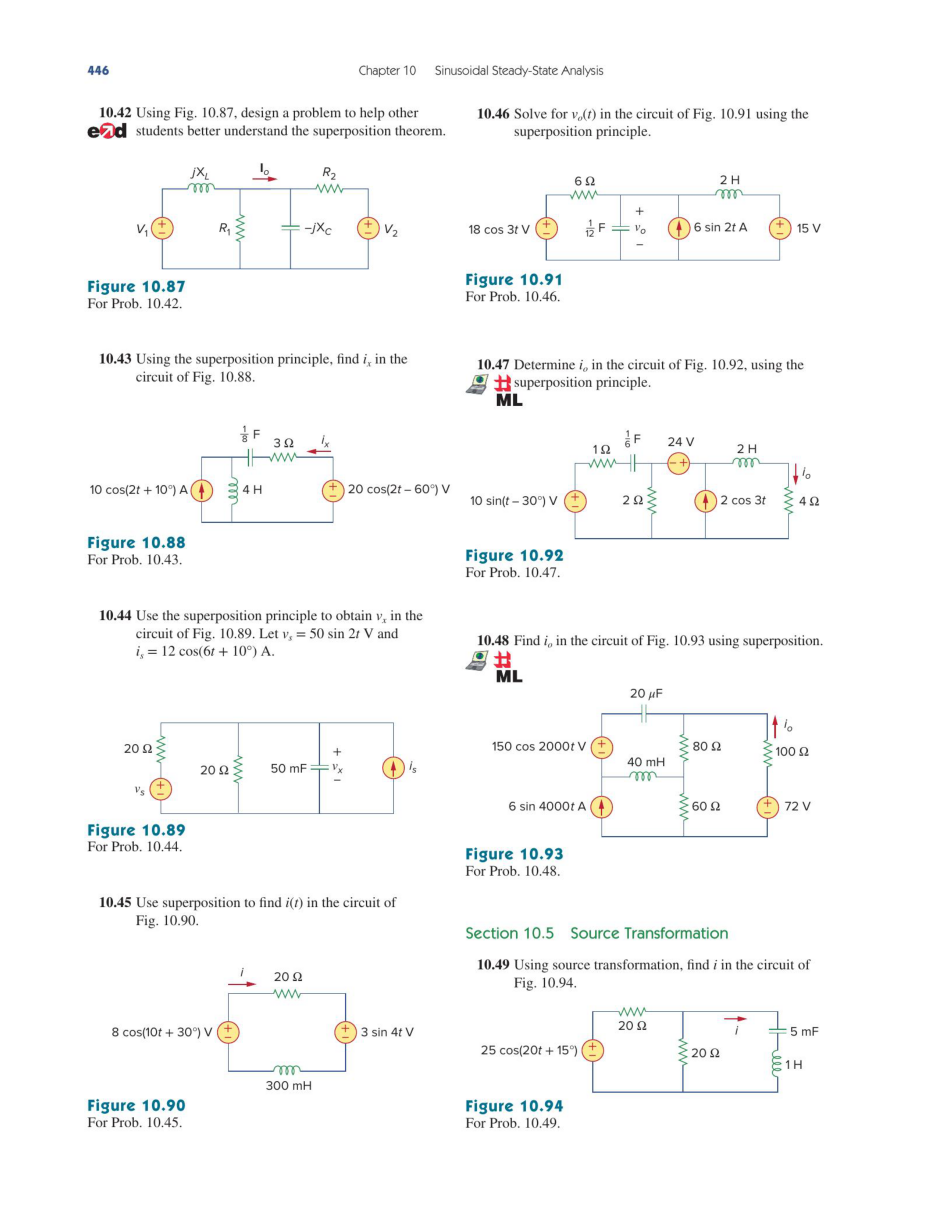

In [ ]:
# Assuming you have already run the main() function
TEST_PAGE = 7
first_page_image = pages_pil[TEST_PAGE]
draw_image(first_page_image)

### Get Contours

In [ ]:
def find_contours(image, kernel_size=3, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Perform Sobel edge detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_magnitude = np.uint8(sobel_magnitude / np.max(sobel_magnitude) * 255)

    # Threshold the Sobel magnitude to create a binary image
    _, binary_image = cv2.threshold(sobel_magnitude, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

contours = [find_contours(page) for page in pages]

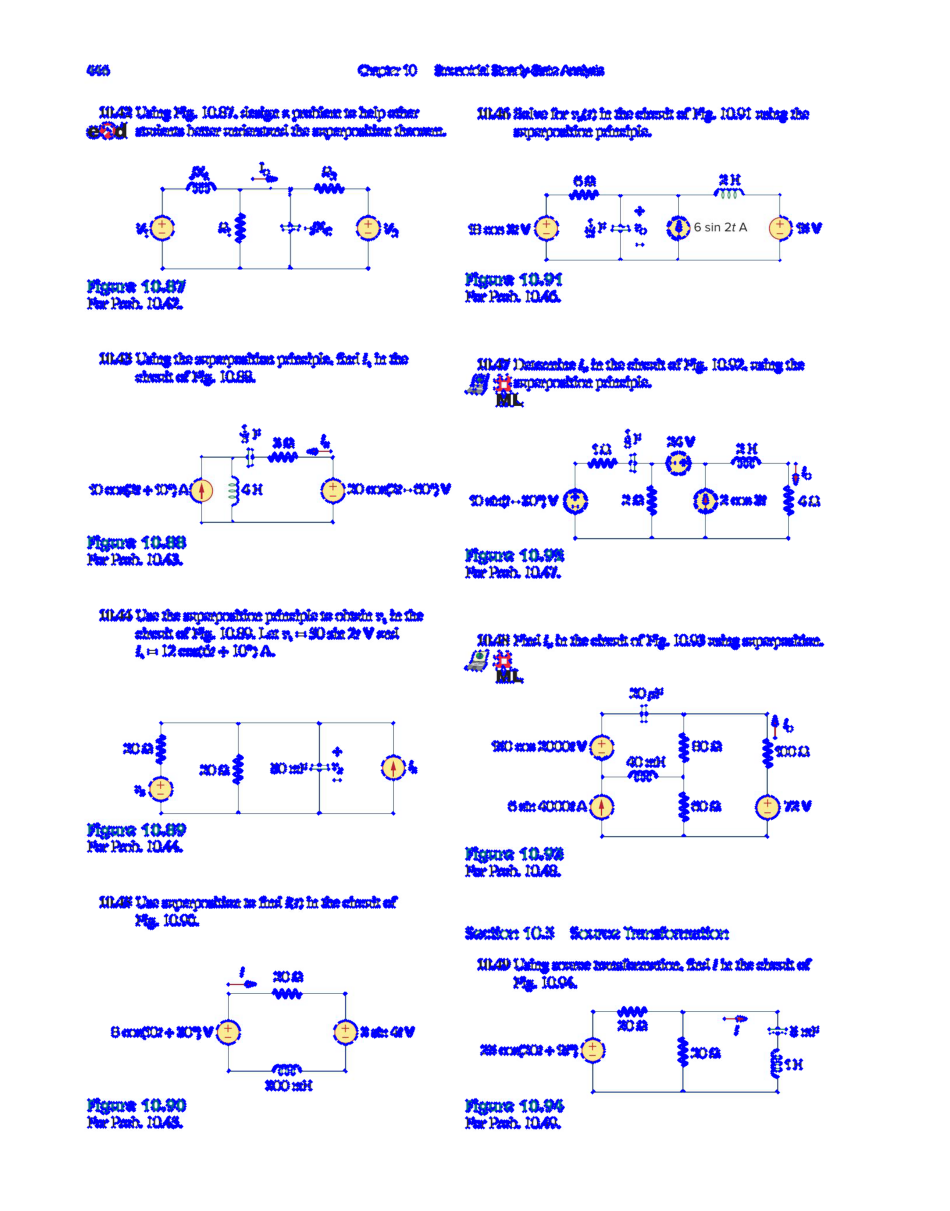

In [ ]:
image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
for contour in contours[TEST_PAGE]:
    for point in contour:
        x, y = point[0]
        cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
draw_image(image_with_dots)

## Get Bounding Boxes

In [ ]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    return image_with_boxes

def get_bounding_boxes(contours, min_length):
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        if w < min_length or h < min_length:
          continue

        yield (x, y, w, h)


min_length = images[0].shape[1] * 0.05
bounding_boxes = [list(get_bounding_boxes(contour, min_length)) for contour in contours]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes[i]) for i in range(len(images))]

draw_image(images_with_boxes[TEST_PAGE])


NameError: ignored

### Remove Overlapping Bounding Boxes

In [ ]:
import copy

def intervals_overlap(intr1, intr2, reversed_call=False):
  # intr1: -------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr2[0] < intr1[1]:
    return True
  # intr1:  -----------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr1[1] > intr2[1]:
    return True

  if not reversed_call:
    return intervals_overlap(intr2, intr1, True)
  else:
    return False

def get_intervals_for_rect(rect):
  x, y, w, h = rect
  xintr = (x, x + w)
  yintr = (y, y + h)
  return xintr, yintr

def merge_rects(rect1, rect2):
  x1, y1, w1, h1 = rect1
  x2, y2, w2, h2 = rect2

  right1 = x1 + w1
  top1 = y1 + h1
  right2 = x2 + w2
  top2 = y2 + h2

  xn = min(x1, x2)
  yn = min(y1, y2)

  rightn = max(right1, right2)
  topn = max(top1, top2)

  wn = rightn - xn
  hn = topn - yn
  return xn, yn, wn, hn

def combine_overlapping_rects(rectangles_input):
    found_overlap = True
    overlapping_indexes = (-1,-1)
    rectangles = copy.deepcopy(rectangles_input)
    while found_overlap:
      found_overlap = False
      for i, rect1 in enumerate(rectangles):
        xintr1, yintr1 = get_intervals_for_rect(rect1)
        for j, rect2 in enumerate(rectangles):
          xintr2, yintr2 = get_intervals_for_rect(rect2)

          if intervals_overlap(xintr1, xintr2) and intervals_overlap(yintr1, yintr2):
            found_overlap = True
            overlapping_indexes = (i, j)
            break
        if found_overlap:
          break

      if found_overlap:
        idx1, idx2 = overlapping_indexes
        rect1 = rectangles[idx1]
        rect2 = rectangles[idx2]
        rectn = merge_rects(rect1, rect2)
        rectangles = [x for i, x in enumerate(rectangles) if i not in overlapping_indexes]
        rectangles.append(rectn)
    return rectangles

bounding_boxes_page = bounding_boxes[TEST_PAGE]
combine_overlapping_rects(bounding_boxes_page)


[(982, 1721, 352, 142),
 (355, 1684, 243, 148),
 (239, 1225, 441, 159),
 (997, 1197, 327, 227),
 (952, 773, 395, 139),
 (309, 755, 267, 129),
 (902, 309, 443, 124),
 (241, 298, 396, 150)]

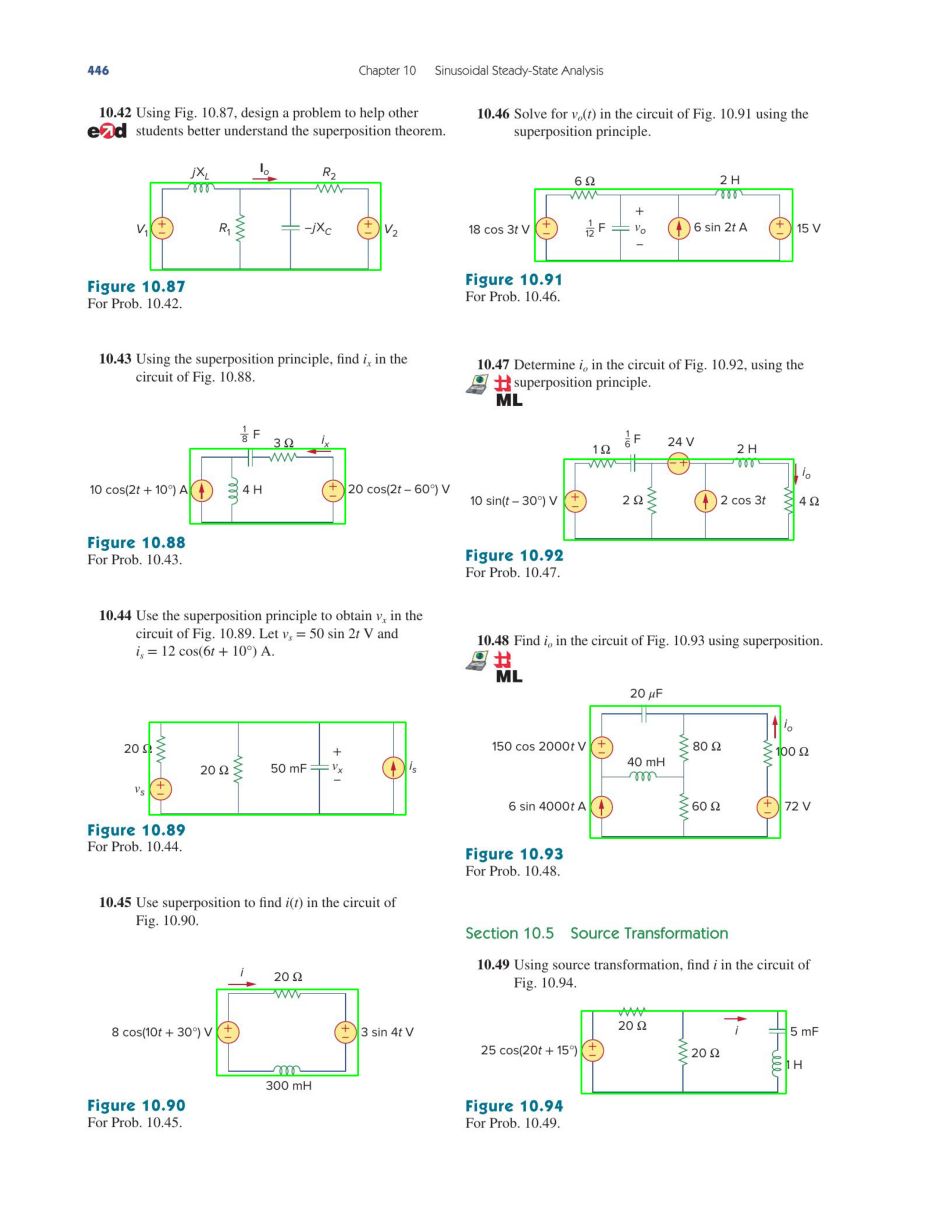

In [ ]:
bounding_boxes_no_ol = [combine_overlapping_rects(list(bounding_boxes_i)) for bounding_boxes_i in bounding_boxes]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes_no_ol[i]) for i in range(len(images))]
draw_image(images_with_boxes[TEST_PAGE])

## Expand bounding boxes to capture unit labels

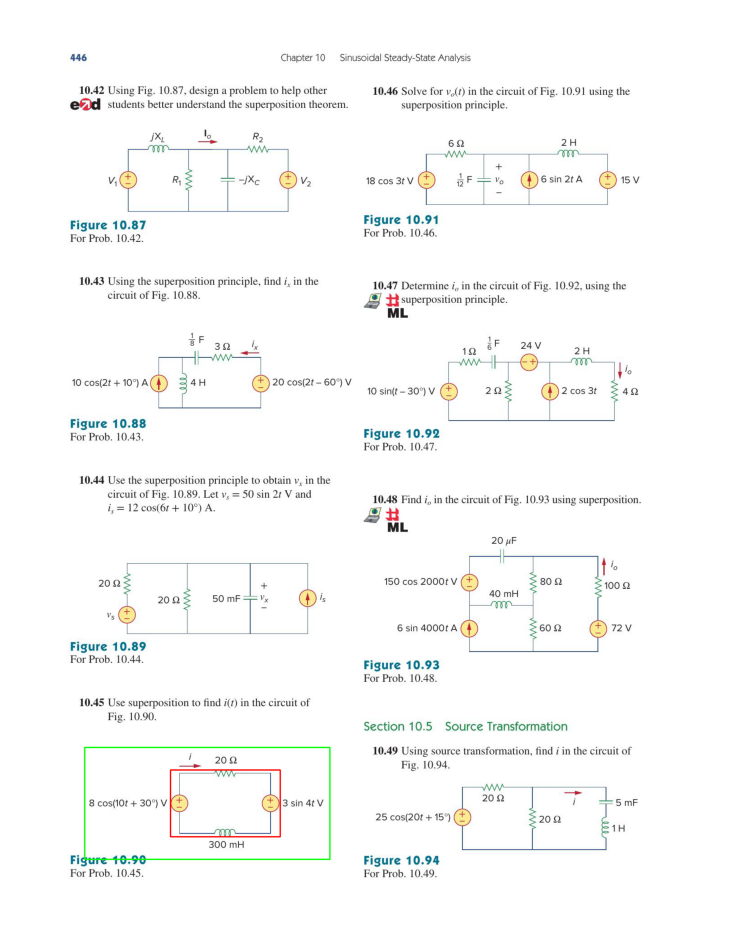

In [ ]:
def get_potential_points_around_bounding_box(bounding_box, contours, max_size):
  x, y, w, h = bounding_box
  x -= max_size
  y -= max_size
  w += 2 * max_size
  h += 2 * max_size

  res = []
  for contour in contours:
    for point in contour:
      px, py = point[0]
      if (x <= px < x + w) and (y <= py < y + h):
        res += [(px, py)]
  return res

def find_points_not_in_box(bounding_box, points):
  x, y, w, h = bounding_box
  new_points = [
      (px, py)
      for px, py in points
      if not ((x <= px < x + w) and (y <= py < y + h))
  ]
  return new_points

def expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding):
  # global images
  # Find all points that it is possible for this process to reach
  max_expansion_for_box = step_size * max_steps
  potential_points = get_potential_points_around_bounding_box(
      bounding_box, contours, max_expansion_for_box
  )

  #  Uncomment to show image with potential points and bounding box labeled
  # image_with_dots = images[1].copy()
  # dot_radius=2
  # color=(0, 0, 255)
  # for point in potential_points:
  #   x, y = point
  #   cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
  # xb, yb, wb, hb = bounding_box
  # cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
  # draw_image(image_with_dots)

  # Expand each surface as number of points captured increases
  right_transform = lambda x, y, w, h: (x, y, w + step_size, h)
  up_transform    = lambda x, y, w, h: (x, y, w, h + step_size)
  left_transform  = lambda x, y, w, h: (x - step_size, y, w + step_size, h)
  down_transform  = lambda x, y, w, h: (x, y - step_size, w, h + step_size)
  transforms = [
      right_transform,
      up_transform,
      left_transform,
      down_transform
  ]
  x, y, w, h = bounding_box
  points_not_in_box = find_points_not_in_box((x, y, w, h), potential_points)
  for transform in transforms:
    for _ in range(max_steps):
      xn, yn, wn, hn = transform(x, y, w, h)
      new_points_not_in_box = find_points_not_in_box((xn, yn, wn, hn), points_not_in_box)
      if len(new_points_not_in_box) == len(points_not_in_box):
        break
      else:
        points_not_in_box = new_points_not_in_box
        x, y, w, h = xn, yn, wn, hn

  x -= fixed_padding
  y -= fixed_padding
  w += 2 * fixed_padding
  h += 2 * fixed_padding

  return x, y, w, h

step_size = 20
max_steps = 20
fixed_padding = 10
max_expansion_for_box = step_size * max_steps

bounding_box = expand_bounding_box(bounding_boxes_no_ol[TEST_PAGE][1], contours[TEST_PAGE], step_size, max_steps, fixed_padding)

image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
xb, yb, wb, hb = bounding_boxes_no_ol[TEST_PAGE][1]
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (255, 0, 0), 2)
xb, yb, wb, hb = bounding_box
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
draw_image(image_with_dots, figsize=(16, 12))

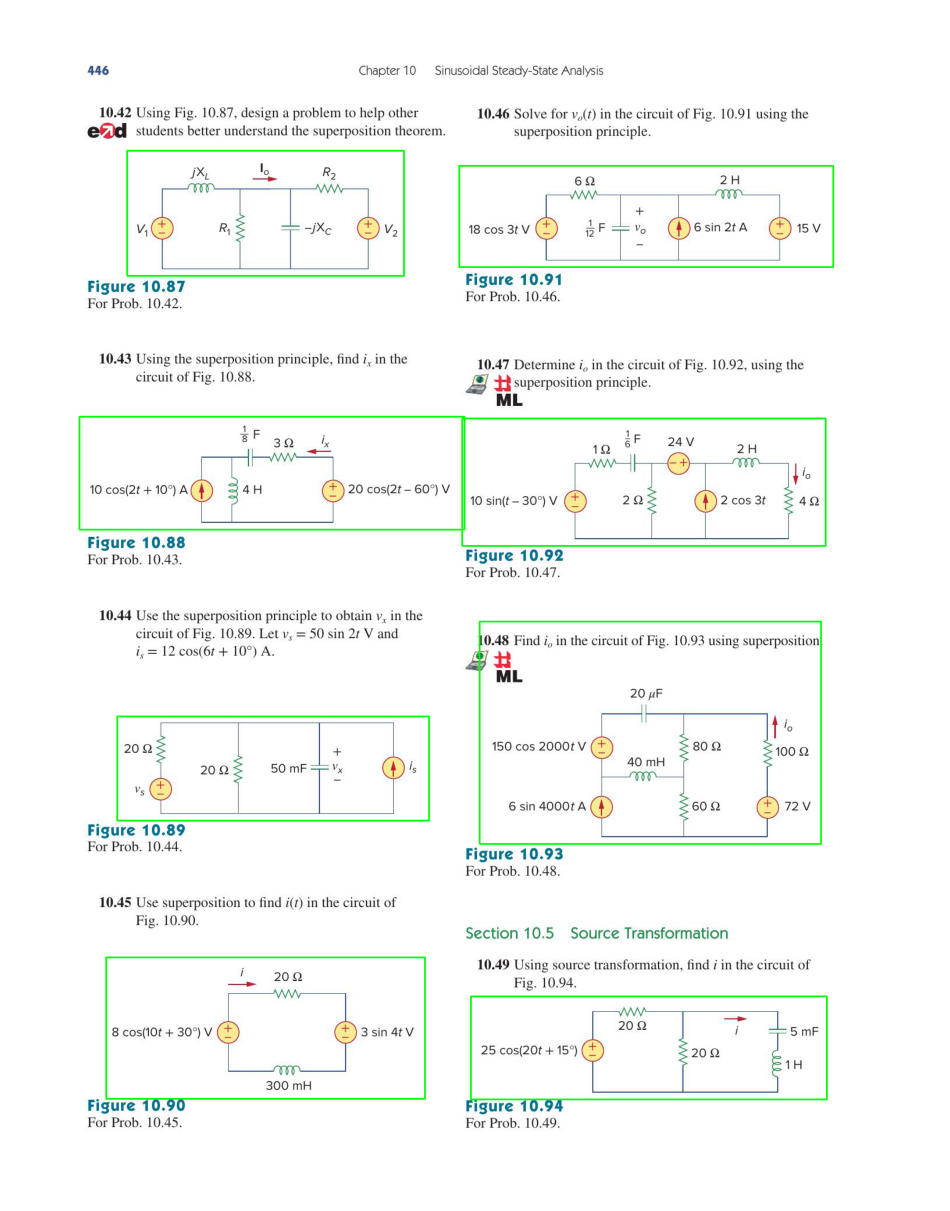

In [ ]:
def expand_bounding_boxes(bounding_boxes, contours, step_size, max_steps, fixed_padding = 10):
  return [
      expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding)
      for bounding_box in bounding_boxes
  ]

max_steps = 20
step_size = 15
fixed_padding = 10
bounding_boxes_expanded = [
    expand_bounding_boxes(bounding_boxes_i, contours_i, step_size, max_steps, fixed_padding)
    for bounding_boxes_i, contours_i in zip(bounding_boxes_no_ol, contours)
]
image_with_box = draw_bounding_boxes(images[TEST_PAGE], bounding_boxes_expanded[TEST_PAGE])
draw_image(image_with_box)

## Extract circuit closeups from bounding boxes and export

In [ ]:
import cv2
import os
import shutil

# Remove the directory and its contents if it exists
if os.path.exists(CIRCUITS_RAW_DIRECTORY):
    shutil.rmtree(CIRCUITS_RAW_DIRECTORY)

# Create a directory to store the close-ups
os.makedirs(CIRCUITS_RAW_DIRECTORY, exist_ok=True)

circuit_images = []
for i, (bounding_boxes, image) in enumerate(zip(bounding_boxes_expanded, images)):
  for j, (x, y, w, h) in enumerate(bounding_boxes):
      circuit_closeup = image[y:y + h, x:x + w]
      circuit_closeup = cv2.cvtColor(circuit_closeup, cv2.COLOR_BGR2GRAY)
      close_up_filename = f'{CIRCUITS_RAW_DIRECTORY}/circuit_page_{i}_circuit_{j}.png'
      cv2.imwrite(close_up_filename, circuit_closeup)
      circuit_images.append(circuit_closeup)

# Part 2. Find Components in circuit

#### Load Circuits from Drive

In [12]:
import cv2
import os
import glob

# Get a list of all image file paths in the directory
image_paths = glob.glob(os.path.join(CIRCUITS_RAW_DIRECTORY, '*.png'))

# Load all images into an array
circuit_images = [cv2.imread(image_path) for image_path in image_paths]

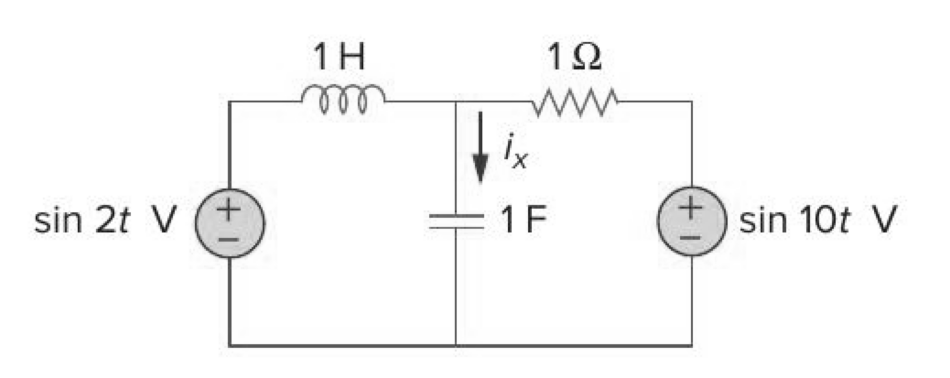

In [13]:
TEST_CIRCUIT = 3

MIN_CONTOUR_LENGTH_ALL = 80
MIN_CONTOUR_LENGTH_VERT = 80
MIN_CONTOUR_LENGTH_HORZ = 80

WIRE_ANGLE_COSINE_THRESHOLD = 0.0001
WIRE_AVG_POINTS = 2

draw_image(circuit_images[TEST_CIRCUIT])

#### Kernal Preprocessing

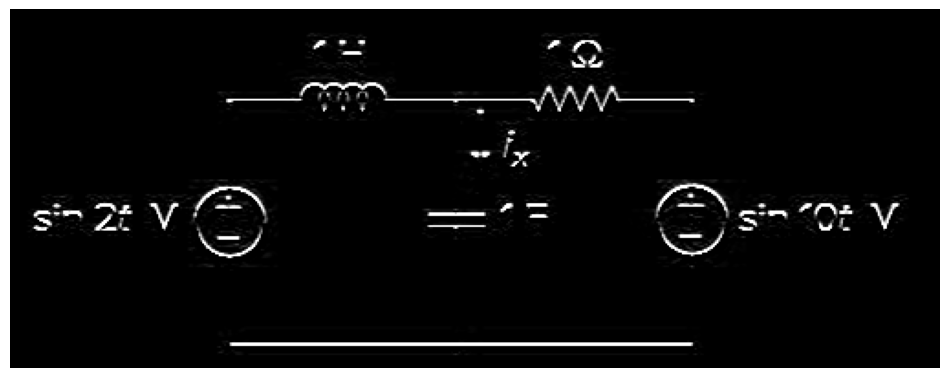

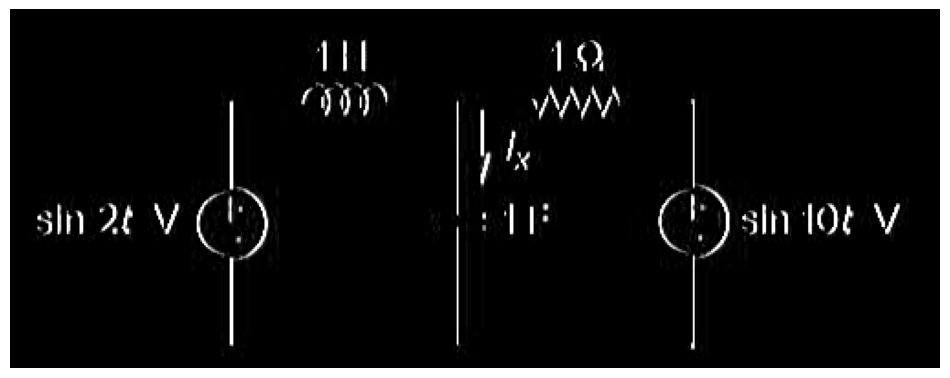

In [14]:
def horz_kernal(image):
  if len(image.shape) == 3 and image.shape[2] > 1:
      # Convert the image to grayscale if it has 3 or 4 channels
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      # If the image is already grayscale, use it directly
      gray_image = image

  # Define a kernel (example: 5x5 Gaussian blur kernel)
  kernel = np.array([
      [1, 2, 1],
      [0, 0, 0],
      [-1, -2, -1],
  ])

  # Apply the kernel to the image
  return cv2.filter2D(gray_image, -1, kernel)

def vert_kernal(image):
  if len(image.shape) == 3 and image.shape[2] > 1:
      # Convert the image to grayscale if it has 3 or 4 channels
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      # If the image is already grayscale, use it directly
      gray_image = image

  # Define a kernel (example: 5x5 Gaussian blur kernel)
  kernel = np.array([
      [-1, 0, 1],
      [-1, 0, 1],
      [-1, 0, 1],
  ])

  # Apply the kernel to the image
  return cv2.filter2D(gray_image, -1, kernel)

circuit_images_horz = list(map(horz_kernal, circuit_images))
circuit_images_vert = list(map(vert_kernal, circuit_images))

draw_image(circuit_images_horz[TEST_CIRCUIT])
draw_image(circuit_images_vert[TEST_CIRCUIT])

#### Get Contours for wires in circuits



<Figure size 640x480 with 0 Axes>

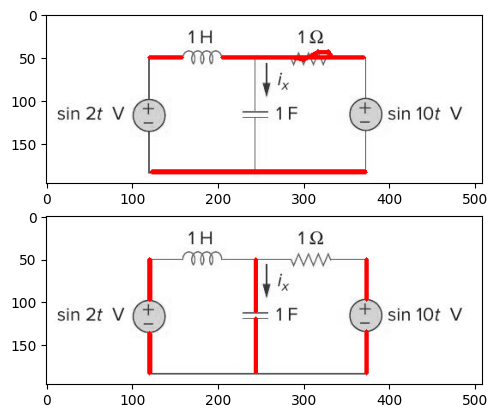

In [15]:
def find_contours_plain(image):

    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours = list(filter(
        lambda c: c.shape[0] > MIN_CONTOUR_LENGTH_ALL,
        contours
    ))

    return contours

def slope_to_angle(slope):
    # Handle the case where the slope is infinity (vertical line)
    if slope == float("inf") or slope == float("-inf"):
        return 90  # The angle of a vertical line is 90 degrees
    # Handle the case where the slope is 0 (horizontal line)
    elif slope == 0:
        return 0   # The angle of a horizontal line is 0 degrees
    else:
        # Compute the angle in degrees for other cases.
        # math.atan returns the arc tangent of slope in radians.
        # math.degrees converts it to degrees.
        return math.degrees(math.atan(slope))

def cosine_difference(angle1, angle2):
    # Convert angles from degrees to radians
    angle1_rad = math.radians(angle1)
    angle2_rad = math.radians(angle2)

    # Compute cosine difference
    cos_diff = math.cos(angle1_rad) * math.cos(angle2_rad) + math.sin(angle1_rad) * math.sin(angle2_rad)
    return cos_diff

# target_angle -> desired angle of wires in degrees
# cosine_angle_threshold -> max cosine difference between target and measdured angle to not filter out line
def filter_contours_by_slope(contours, target_angle, cosine_angle_threshold, n):
    horizontal_contours_list = []

    for contour in contours:
        horizontal_points = []
        i = 0
        while i < len(contour) - 2 * n:
            avg_pt1 = np.mean(contour[i:i + n], axis=0)[0]
            avg_pt2 = np.mean(contour[i + n:i + 2 * n], axis=0)[0]

            # Calculate the slope of the line segment between avg_pt1 and avg_pt2
            if avg_pt2[0] != avg_pt1[0]:
                slope = (avg_pt2[1] - avg_pt1[1]) / (avg_pt2[0] - avg_pt1[0])
            else:
                slope = float("inf")

            angle = slope_to_angle(slope)

            # Use ABS since we dont care about the direction of the wire
            cosine_dif = abs(cosine_difference(angle, target_angle))

            # Check if the slope is within the threshold
            if (1 - cosine_dif) <= cosine_angle_threshold:
                horizontal_points.extend(contour[i:i + 2 * n].tolist())
                i += n
            else:
                i += 2 * n

        if horizontal_points:
            horizontal_contours_list.append(np.array(horizontal_points))

    return horizontal_contours_list

def filter_wires_by_slope(images, target_angle, min_length):
  # utility to filter out contours under specified length
  filter_small_contours = lambda contours_circuit: \
    list(filter(
      lambda x: len(x) >= min_length,
      contours_circuit
    ))

  contours = list(map(find_contours_plain, images))
  contours_aligned = list(map(
      partial(
          filter_contours_by_slope,
          target_angle=target_angle,
          cosine_angle_threshold=WIRE_ANGLE_COSINE_THRESHOLD,
          n=WIRE_AVG_POINTS
      ),
      contours
  ))
  contours_aligned_min_length = list(map(
      filter_small_contours,
      contours_aligned
  ))
  return contours_aligned_min_length

# Horizontal processing
contours_horz = filter_wires_by_slope(
    images=circuit_images_horz,
    target_angle=0,
    min_length=MIN_CONTOUR_LENGTH_HORZ
)

# Vertical Processing
contours_vert = filter_wires_by_slope(
    images=circuit_images_vert,
    target_angle=90,
    min_length=MIN_CONTOUR_LENGTH_VERT
)

# Print out test circuits
plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_horz[TEST_CIRCUIT],
    -1, 255, 3
))
axarr[1].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_vert[TEST_CIRCUIT],
    -1, 255, 3
))

### Find Bounding Boxes

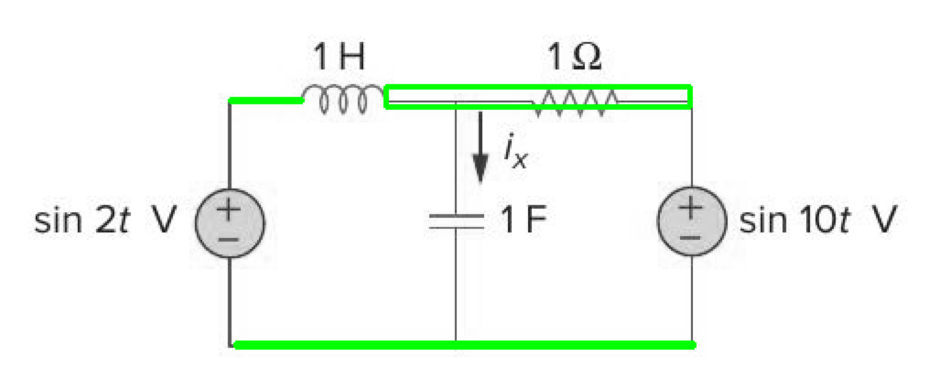

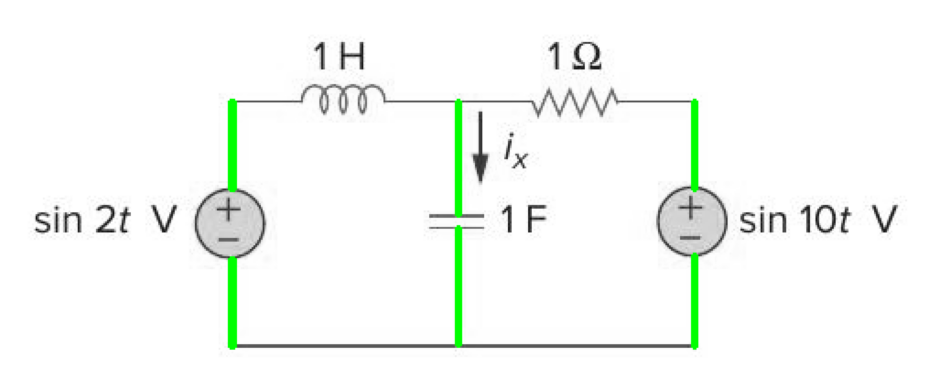

In [16]:
def get_horizontal_lines(contours, min_size = 0):
    horizontal_line_heights = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        horizontal_line_heights.append(int(y + h/2))

    return horizontal_line_heights

def get_bounding_boxes(contours):
    return list(map(cv2.boundingRect, contours))

def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    draw_image(image_with_boxes)

def draw_horizontal_lines_bb(image, contours, line_heights):
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw red horizontal lines at the heights of detected lines
    for h in line_heights:
        print('h: ' + str(h))
        cv2.line(image_rgb, (0, h), (image_rgb.shape[1], h), (255, 0, 0), 2)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with the red lines using plt.imshow
    plt.imshow(image_rgb)
    plt.show()

bounding_boxes_horz = list(map(get_bounding_boxes, contours_horz))
draw_bounding_boxes(circuit_images[TEST_CIRCUIT], bounding_boxes_horz[TEST_CIRCUIT])

bounding_boxes_vert = list(map(get_bounding_boxes, contours_vert))
draw_bounding_boxes(circuit_images[TEST_CIRCUIT], bounding_boxes_vert[TEST_CIRCUIT])

# line_heights = get_horizontal_lines(contours_horz[TEST_CIRCUIT])
# draw_horizontal_lines_bb(circuit_images[TEST_CIRCUIT], contours_horz[TEST_CIRCUIT], line_heights)

### Merge overlapping bounding boxes.

Fixes when more than just wires are bounded by bounding boxes

<Figure size 640x480 with 0 Axes>

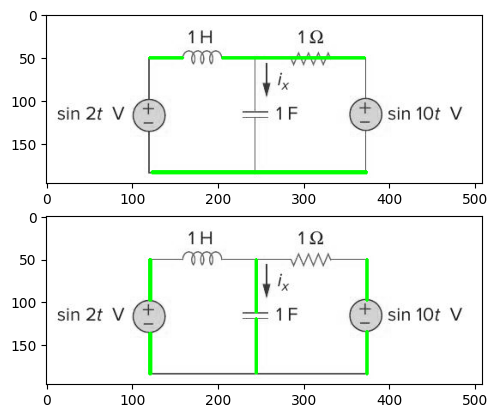

In [17]:
def image_with_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    return image_with_boxes

def intervals_overlap(intr1, intr2, reversed_call=False):
  # intr1: -------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr2[0] < intr1[1]:
    return True
  # intr1:  -----------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr1[1] > intr2[1]:
    return True

  if not reversed_call:
    return intervals_overlap(intr2, intr1, True)
  else:
    return False

def union_bounding_boxes(bounding_boxes, dim):
  left = -1
  right = float("inf")
  for x, y, w, h in bounding_boxes:
    if dim == 0:
      left = max(left, x)
      right = min(right, x + w)
    else:
      left = max(left, y)
      right = min(right, y + h)

  length = right - left

  bounding_boxes_union = [
      (left, y, length, h) if dim == 0 else (x, left, w, length)
      for x, y, w, h in bounding_boxes
  ]

  return bounding_boxes_union

def merge_overlapping_bounding_boxes(bounding_boxes, dim):
  # Find overlapping intervals
  overlapping_intr_map = {}
  overlapping_intrs = set()
  non_overlapping_intrs = set(range(len(bounding_boxes)))
  for i, (x1, y1, w1, h1) in enumerate(bounding_boxes[:-1]):
    for j, (x2, y2, w2, h2) in enumerate(bounding_boxes[i+1:]):

      intr1 = None
      intr2 = None
      if dim == 0:
        intr1 = [x1, x1 + w1]
        intr2 = [x2, x2 + w2]
      elif dim == 1:
        intr1 = [y1, y1 + h1]
        intr2 = [y2, y2 + h2]
      else:
        raise Exception(f"invalid dim = {dim}")

      if intervals_overlap(intr1, intr2):
        overlapping_intrs.add(i)
        non_overlapping_intrs.discard(i)
        non_overlapping_intrs.discard(1 + i + j)
        overlapping_intr_map[i] = 1 + i + j

  #find groups of overlapping intervals
  overlapping_bounding_boxes_grouped = []
  while len(overlapping_intrs) > 0:
    intr_group = []
    cur = next(iter(overlapping_intrs))
    while True:
      intr_group.append(bounding_boxes[cur])
      overlapping_intrs.discard(cur)
      if cur in overlapping_intr_map:
        cur = overlapping_intr_map[cur]
      else:
        break
    overlapping_bounding_boxes_grouped.append(intr_group)

  # the final bounding boxes will contain all bounding boxes not overlapping
  final_bounding_boxes = [bounding_boxes[i] for i in non_overlapping_intrs]
  for overlapping_group in overlapping_bounding_boxes_grouped:
    final_bounding_boxes.extend(
        union_bounding_boxes(overlapping_group, dim)
    )

  return final_bounding_boxes

bounding_boxes_horz_merged = list(map(
    partial(merge_overlapping_bounding_boxes, dim=1),
    bounding_boxes_horz
))
bounding_boxes_vert_merged = list(map(
    partial(merge_overlapping_bounding_boxes, dim=0),
    bounding_boxes_vert
))

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_bounding_boxes(
    circuit_images[TEST_CIRCUIT].copy(),
    bounding_boxes_horz_merged[TEST_CIRCUIT]
))
axarr[1].imshow(image_with_bounding_boxes(
    circuit_images[TEST_CIRCUIT].copy(),
    bounding_boxes_vert_merged[TEST_CIRCUIT]
))

### Corner Detection

##### Step 1. Use Harris Corner Detection, and filter for corners inside bounding boxes from previous step

<Figure size 640x480 with 0 Axes>

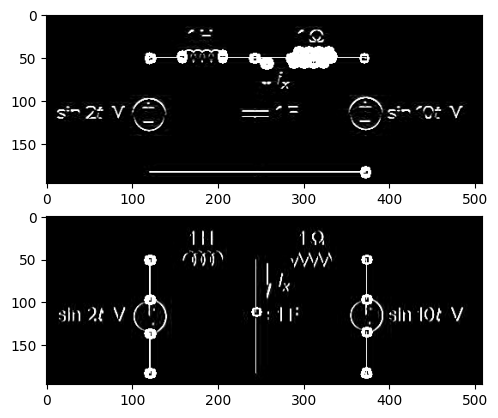

In [18]:
import cv2
import numpy as np


def get_corners(img, bounding_boxes, dim, wire_padding):
    if len(img.shape) == 2:
        # The image is grayscale. Convert it to BGR.
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Harris corner detection
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    # Dilate to enhance corner points
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, it may vary depending on the image.
    corner_mask = dst > 0.1 * dst.max()

    # Get corner coordinates
    corner_coordinates = np.argwhere(corner_mask)

    # Filter corner points by checking if they are within any of the bounding boxes
    def filter_cond(x, y, box):
      if dim == 0:
        return x >= box[0] and x <= box[0] + box[2] and y >= box[1] - wire_padding and y <= box[1] + box[3] + wire_padding
      else:
        return x >= box[0] - wire_padding and x <= box[0] + box[2] + wire_padding and y >= box[1] and y <= box[1] + box[3]
    filtered_corner_coordinates = [
        (x, y)
        for y, x in corner_coordinates
        if any(
            filter_cond(x, y, box)
            for box in bounding_boxes
        )
    ]

    return filtered_corner_coordinates

corners_horz_harris = [
    get_corners(image, bounding_boxes, 0, 10)
    for image, bounding_boxes in zip(circuit_images_horz, bounding_boxes_horz_merged)
]
corners_vert_harris = [
    get_corners(image, bounding_boxes, 1, 10)
    for image, bounding_boxes in zip(circuit_images_vert, bounding_boxes_vert_merged)
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz_harris[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert_harris[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

##### Step 2. Append corners of previously found bounding boxes

corners_vert_bb
(121, 136)
(121, 184)
(373, 134)
(373, 184)
(244, 119)
(244, 183)
(244, 50)
(244, 112)
(121, 50)
(121, 98)
(373, 50)
(373, 98)


<Figure size 640x480 with 0 Axes>

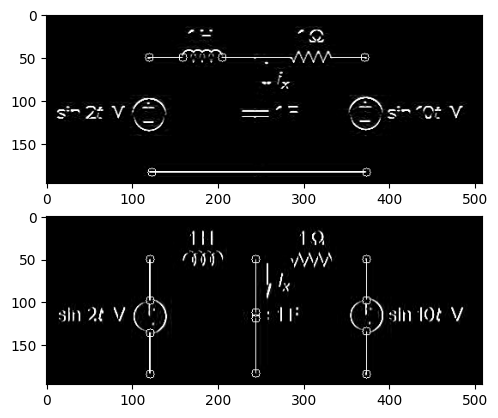

In [20]:
def get_corners_bounding_boxes(bounding_boxes, dim):
  corners = []
  for bounding_box in bounding_boxes:
    x1, y1, w1, h1 = bounding_box
    if dim == 0:
      yavg = y1 + h1 // 2
      corners += [(x1, yavg), (x1 + w1, yavg)]
    else:
      xavg = x1 + w1 // 2
      corners += [(xavg, y1), (xavg, y1 + h1)]
  return corners

corners_horz_bb = [
    get_corners_bounding_boxes(bounding_boxes, dim=0)
    for image, bounding_boxes in zip(circuit_images_horz, bounding_boxes_horz_merged)
]
corners_vert_bb = [
    get_corners_bounding_boxes(bounding_boxes, dim=1)
    for image, bounding_boxes in zip(circuit_images_vert, bounding_boxes_vert_merged)
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz_bb[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

print("corners_vert_bb")
print("\n".join(str(val) for val in corners_vert_bb[TEST_CIRCUIT]))
image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert_bb[TEST_CIRCUIT]:
# for x, y in [(121, 184)]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

#### Step 3. Merge Harris and Bounding Box corners

<Figure size 640x480 with 0 Axes>

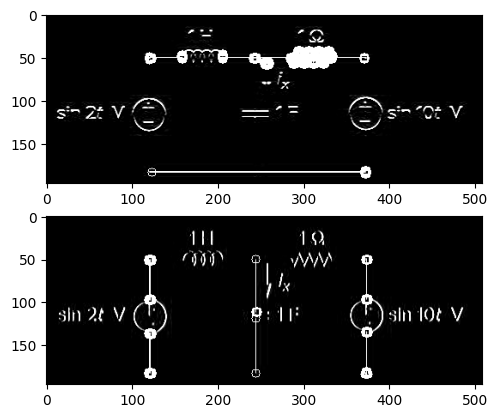

In [21]:
corners_horz = [
    corners_horz_harris[i] + corners_horz_bb[i]
    for i in range(len(corners_horz_harris))
]
corners_vert = [
    corners_vert_harris[i] + corners_vert_bb[i]
    for i in range(len(corners_horz_harris))
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

#### Step 4. Delete corners in both vertical and horizontal

<Figure size 640x480 with 0 Axes>

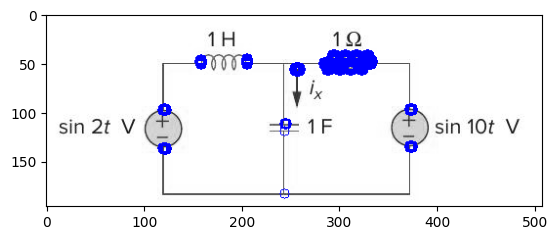

In [22]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def combined_list(A, B, threshold):
    F = A + B
    for a in A:
        for b in B:
            if euclidean_distance(a, b) < threshold:
                if a in F: F.remove(a)
                if b in F: F.remove(b)
    return F

corners = [
    combined_list(corners_horz_i, corners_vert_i, 10)
    for corners_horz_i, corners_vert_i in zip(corners_horz, corners_vert)
]

image_with_corners = circuit_images[TEST_CIRCUIT].copy()
for x, y in corners[TEST_CIRCUIT]:
    cv2.circle(image_with_corners, (x, y), 5, (255, 0, 0), 1)
image_with_corners = cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,1)
axarr.imshow(image_with_corners)

### Cluster corner points + filter to find component locations



Steps

1.   Run cluster algorithm
2.   Compute
```
avg_dist = 0
for p in cluster:
  avg_dist += dist(p, centroid)
```
3. If this average is too small, throw away cluster. This is clearly not a component it is too small


<Figure size 640x480 with 0 Axes>

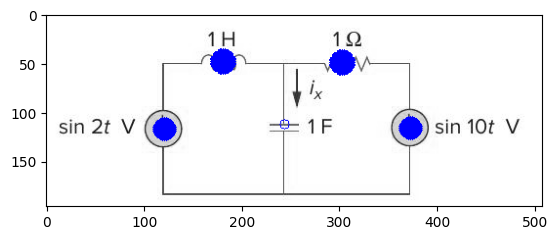

In [51]:
from sklearn.cluster import DBSCAN
import numpy as np

def euclidian_std(points, mean_point):
  # Compute squared differences from the mean
  squared_diffs = (points - mean_point)**2

  # Compute mean of squared differences
  variance = np.mean(squared_diffs)

  # Compute standard deviation as square root of variance
  return np.sqrt(variance)

def merge_close_points(F, distance_threshold, stddev_threshold):
    # Perform DBSCAN on F with the specified distance threshold
    clustering = DBSCAN(eps=distance_threshold, min_samples=1).fit(F)

    # Create a list to hold the averaged points
    averaged_points = []

    # For each cluster label, average the points in that cluster
    for cluster_id in set(clustering.labels_):
        # Get the points in the current cluster
        cluster_points = np.array([F[i] for i in range(len(F)) if clustering.labels_[i] == cluster_id])

        # Compute the mean of the points in the cluster
        mean_point = np.mean(cluster_points, axis=0)

        stddev = euclidian_std(cluster_points, mean_point)

        # Check if the maximum standard deviation across dimensions is below the threshold
        if np.max(stddev) >= stddev_threshold and len(cluster_points) > 1:
            # Compute the centroid of the cluster and append to the averaged points list
            centroid = np.mean(cluster_points, axis=0)
            averaged_points.append((
                (int(centroid[0]), int(centroid[1])),
                stddev
            ))

    return averaged_points

corners_join_nearby = [
    merge_close_points(corners_i, 46, 1)
    for corners_i in corners
]

image_with_corners = circuit_images[TEST_CIRCUIT].copy()
for (x, y), radius in corners_join_nearby[TEST_CIRCUIT]:
    cv2.circle(image_with_corners, (x, y), 5, (255, 0, 0), int(radius))
image_with_corners = cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,1)
axarr.imshow(image_with_corners)

Create fixed bounding boxes around

In [ ]:
import numpy as np

A = [(1,2), (1,2)]
np.std(A)